#### Import and mount drive

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from skimage.io import imread

import torch
from torch.utils.data import Dataset
import torchvision 
from torchvision import datasets, transforms, utils
from torchsummary import summary
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
if not os.path.exists("pytorch_unet.py"):
  if not os.path.exists("pytorch_unet"):
    !git clone https://github.com/usuyama/pytorch-unet.git

  %cd pytorch-unet

import pytorch_unet
%cd /content

In [ ]:
root_directory = Path("/content/")
drive_path = root_directory / 'drive/MyDrive' / 'CS101' 

#### Data preparation

In [ ]:
# Path to zip file in my drive
!unzip '/content/drive/My Drive/CS101/CS101.zip'

In [ ]:
class EmbryoDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data_dir = data_dir
    image_list_file = os.path.join(self.data_dir, 'DIC.list') 
    gt_list_file = os.path.join(self.data_dir, 'gt_boundary.list')   
    with open(image_list_file, 'r') as f:
      self.image_list = f.read().splitlines()
    with open(gt_list_file, 'r') as f:
      self.gt_list = f.read().splitlines()
    self.data_dir = data_dir
    self.length = len(self.image_list)
    self.transform = transform

  def __getitem__(self, index):
    image_path = os.path.join(self.data_dir, self.image_list[index]) 
    gt_path = os.path.join(self.data_dir, self.gt_list[index])
    image = imread(image_path, as_gray=True)
    gt = imread(gt_path, as_gray=True)
    image = self.image_transform(image)
    gt = self.gt_transform(gt)
    return image, gt

  def __len__(self):
    return self.length

  def image_transform(self, image):
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.4111], [0.2077])])
    return trans(image)

  def gt_transform(self, gt):
    gt = gt / 255.0
    trans = transforms.ToTensor()
    return trans(gt)

In [ ]:
train_set = EmbryoDataset(root_directory / 'CS101_z' / 'trainset')
test_set = EmbryoDataset(root_directory / 'CS101_z' / 'testset')
val_set = EmbryoDataset(root_directory / 'CS101_z' / 'valset')

batch_size = 8

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

dataloaders = {"train": train_loader, "test": test_loader, "val": val_loader}

#### Declare model

In [ ]:
import torch.nn as nn
import torchvision.models
from collections import OrderedDict

class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

#### Declare training Loop

In [ ]:
from collections import defaultdict
import torch.nn.functional as F
%cd pytorch-unet
from loss import dice_loss
%cd /content

# define loss function
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    #pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

# define helper function to print metrics
def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, checkpoint_path，num_epochs=25):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
                print_metrics(metrics, epoch_samples, phase)
                iteration = epoch_samples // inputs.size(0)
                if iteration % 100 == 1 and phase == 'train':
                    torch.save(model.state_dict(), os.path.join(checkpoint_path, '{}_{}.pth'.format(epoch, iteration)))

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                  best_loss = epoch_loss
                  torch.save(model.state_dict(), os.path.join(checkpoint_path, 'best.pth'))
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val loss: {:4f}'.format(best_loss))

#### Train model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)
model = UNet().to(device)

# when traing, change to your own checkpoint path
checkpoint_path = drive_path / 'exps' / 'jiajun' / 'exp16' / 'checkpoints'

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=16)

#### Visualize the results

device cpu


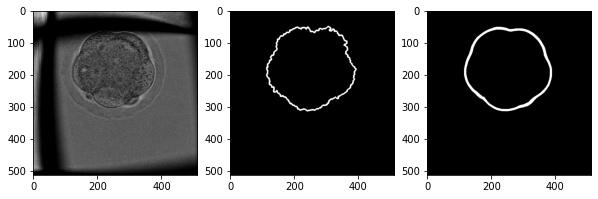

In [ ]:
device = torch.device('cpu')
print('device', device)

model = UNet().to(device)
cp_path = "/content/drive/Shareddrives/CS101 - Embryonic Cells/checkpoints/jiajun/new_checkpoints/boundary_detection.pth"
cp = torch.load(cp_path, map_location=torch.device('cpu'))
model.load_state_dict(cp['state_dict'])
model.eval()

images, masks = next(iter(test_loader))

outputs = model(images)

predict_map = outputs[0]
image = images[0]
mask = masks[0]

def imshow(image, mask, predict_map):
  image = image.numpy().transpose((1,2,0))
  mask = mask.numpy().transpose((1,2,0))
  predict_map = predict_map.detach().numpy().transpose((1,2,0))
  fig = plt.figure(figsize = (10, 10))
  ax1 = fig.add_subplot(131)
  plt.imshow(image[:,:,0], cmap='gray')
  ax2 = fig.add_subplot(132)
  plt.imshow(mask[:,:,0], cmap='gray')
  ax3 = fig.add_subplot(133)
  plt.imshow(predict_map[:,:,0], cmap='gray')

imshow(image, mask, predict_map)